In [1]:
%pylab inline
%load_ext autoreload
%autoreload 2

%aimport manual_review_classifier

Populating the interactive namespace from numpy and matplotlib


In [2]:
%matplotlib inline

In [3]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
# import seaborn as sns
from itertools import cycle

from sklearn import metrics
from sklearn.model_selection import train_test_split

from manual_review_classifier.ClassifierPlots import create_reliability_diagram, create_roc_curve

# sns.set_style("white")
# sns.set_context('poster')

In [4]:
training_data = pd.read_pickle('../data/training_data.pkl')
training_data.sort_index(axis=1, inplace=True)
# remove validation sample
training_data = training_data[~training_data.index.str.contains('H_KA-452198')]

In [5]:
# Get training data as numpy array
X = training_data.drop(['call'], axis=1).astype(float).values
# Get Labels
three_class = training_data.replace('g', 'f')
Y = pd.get_dummies(three_class.call).astype(float).values
# fix random seed for reproducibility
seed = 7
np.random.seed(seed)
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.33, random_state=seed)

In [6]:
threeclass_relu_probs = np.load('../data/deep_learning/threeclass_regularization.npy')

In [7]:
logr_probs = np.load('../data/log_reg/threeclass_relu_probs.npy')

In [8]:
forest = np.load('../data/random_forest/1000estimators.npy')

confidence intervals +-:  [ 0.00159393  0.00533031  0.00497537  0.01044351  0.01550653  0.02165061
  0.02870916  0.04769853  0.05305761  0.00486715]
confidence intervals +-:  [ 0.00059356  0.00330018  0.00590746  0.00820556  0.00934387  0.00997724
  0.00906077  0.00676855  0.00418852  0.00070047]
confidence intervals +-:  [ 0.00062248  0.00456623  0.0074501   0.009447    0.01037292  0.01143201
  0.01109529  0.00861871  0.00542386  0.00122206]


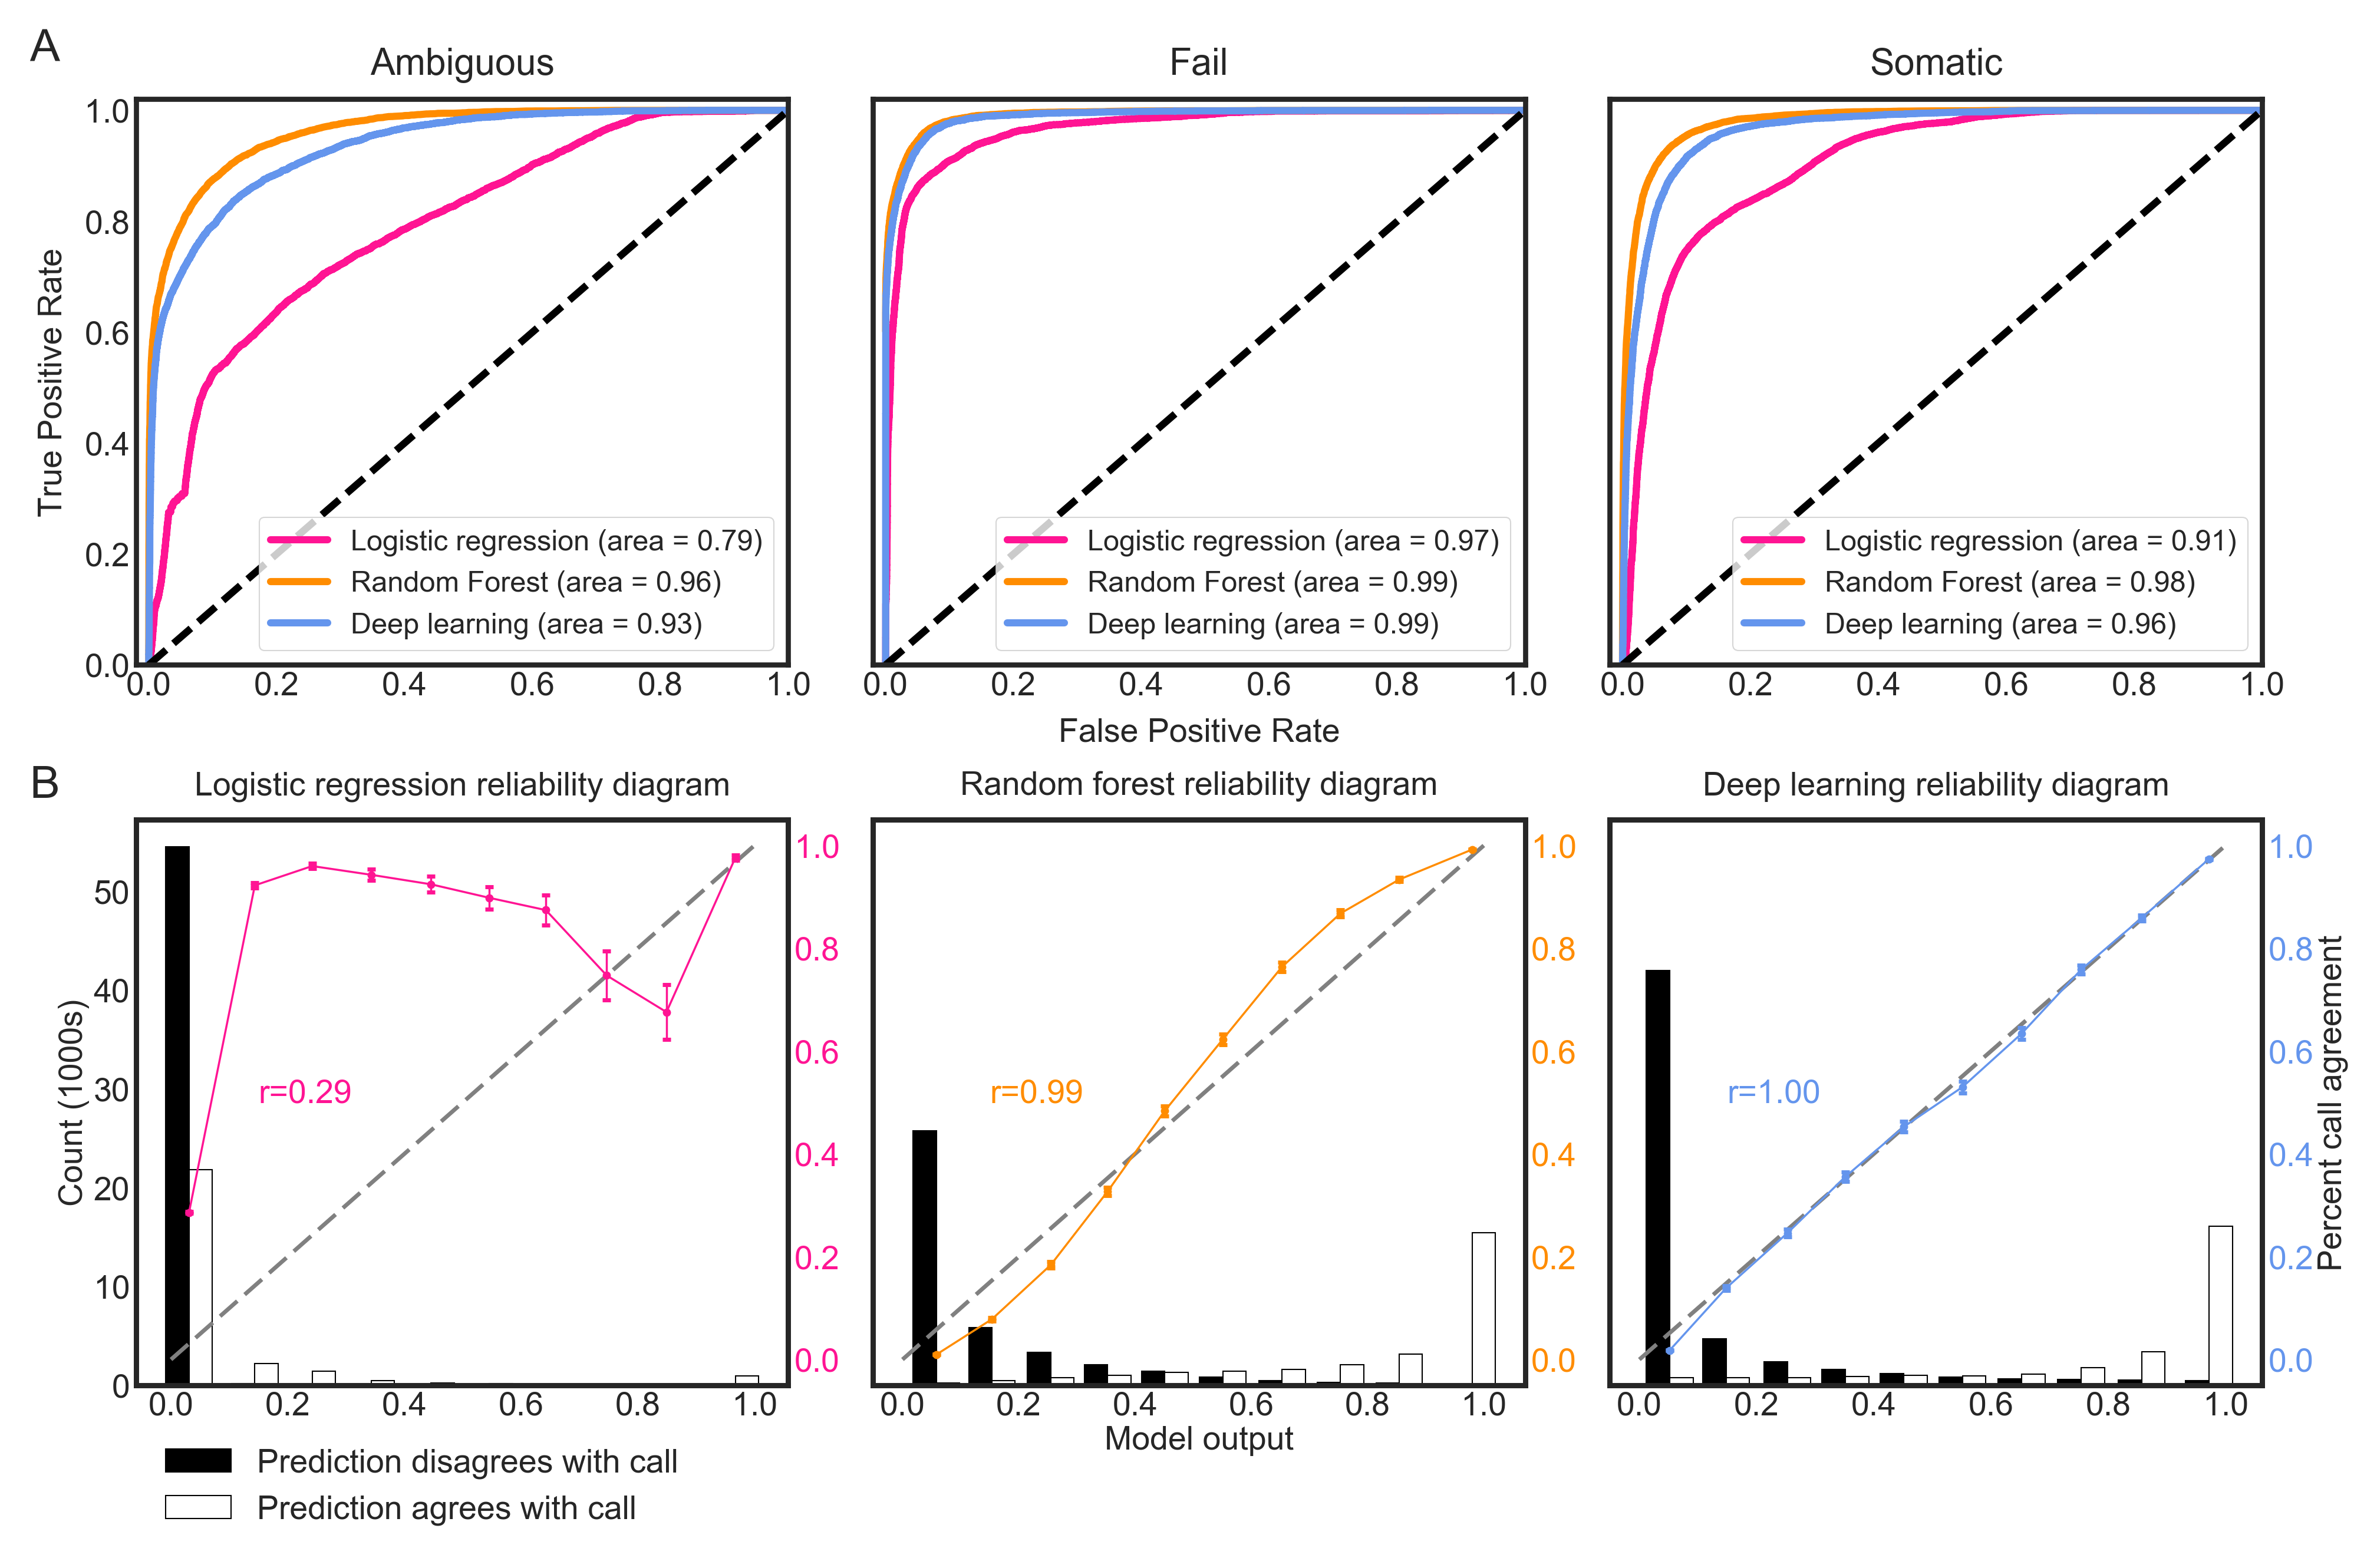

In [9]:
n_classes = Y_train.shape[1]
class_lookup = {0: 'Ambiguous', 1: 'Fail', 2: 'Somatic'}
dl_fpr = dict()
dl_tpr = dict()
dl_roc_auc = dict()
lr_fpr = dict()
lr_tpr = dict()
lr_roc_auc = dict()
rf_fpr = dict()
rf_tpr = dict()
rf_roc_auc = dict()
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'deeppink'])
fig, axes = plt.subplots(2, 3, sharey='row', figsize=(8, 5), dpi=500)
plt.tight_layout(w_pad=.1, h_pad=1.5)
# fig.suptitle('Receiver Operating Characteristic')
ax_array = axes[0].flatten()
for i, color in zip(range(n_classes), colors):
    lr_fpr[i], lr_tpr[i], _ = metrics.roc_curve(Y_train[:, i], logr_probs[:, i])
    lr_roc_auc[i] = metrics.auc(lr_fpr[i], lr_tpr[i])
    ax_array[i].plot(lr_fpr[i], lr_tpr[i], color='deeppink', label='Logistic regression'
             ' (area = {0:0.2f})'.format(lr_roc_auc[i]))
    rf_fpr[i], rf_tpr[i], _ = metrics.roc_curve(Y_train[:, i], forest[:, i])
    rf_roc_auc[i] = metrics.auc(rf_fpr[i], rf_tpr[i])
    ax_array[i].plot(rf_fpr[i], rf_tpr[i], color='darkorange', label='Random Forest'
             ' (area = {0:0.2f})'.format(rf_roc_auc[i]))
    dl_fpr[i], dl_tpr[i], _ = metrics.roc_curve(Y_train[:, i], threeclass_relu_probs[:, i])
    dl_roc_auc[i] = metrics.auc(dl_fpr[i], dl_tpr[i])
    ax_array[i].plot(dl_fpr[i], dl_tpr[i], color='cornflowerblue', label='Deep learning'
             ' (area = {0:0.2f})'.format(dl_roc_auc[i]))
    ax_array[i].set_title(class_lookup[i], fontsize=9)
    ax_array[i].plot([0, 1], [0, 1], 'k--')
    ax_array[i].legend(loc="lower right", fontsize=7, frameon=True)
    ax_array[i].set_xlim([-0.02, 1.0])
    ax_array[i].set_ylim([0.0, 1.02])
    ax_array[i].tick_params(labelsize=8, pad=1.5)
# ax.xlabel('False Positive Rate')
# ax.ylabel('True Positive Rate')
axes[0,0].set_ylabel('True Positive Rate', fontsize=8)
axes[0,1].set_xlabel('False Positive Rate', fontsize=8)
# fig.text(0.5, 0.05, 'False Positive Rate', ha='center', va='center', fontsize=8)
# fig.text(0.07, 0.5, 'True Positive Rate', ha='center', va='center', rotation='vertical', fontsize=8)

# plt.subplots_adjust(left=0.1, top=.85, wspace=.09)
lgd = create_reliability_diagram(logr_probs, Y_train,['Ambiguous','Fail','Somatic'], 'deeppink', 'Logistic regression reliability diagram', 
                           axes[1,0], False, True, True)
create_reliability_diagram(forest, Y_train,['Ambiguous','Fail','Somatic'], 'darkorange', 'Random forest reliability diagram', 
                           axes[1,1], False, False, False)
create_reliability_diagram(threeclass_relu_probs, Y_train,['Ambiguous','Fail','Somatic'], 'cornflowerblue', 'Deep learning reliability diagram', 
                           axes[1,2], True, False, False)
axes[1,0].set_xlabel('')
axes[1,2].set_xlabel('')
lgd.set_bbox_to_anchor((0, -0.3))
fig.text(.02, .98, 'A', ha='center', fontsize=11)
fig.text(.02, .48, 'B', ha='center', fontsize=11)

plt.show()

fig.savefig('../figures/cv_performance.png', bbox_extra_artists=(lgd,), bbox_inches='tight')
fig.savefig('../figures/cv_performance.pdf', bbox_extra_artists=(lgd,), bbox_inches='tight')

confidence intervals +-:  [ 0.00135697  0.00597271  0.00959394  0.01293291  0.01499473  0.01900697
  0.01987522  0.01710728  0.01035055  0.00301243]
confidence intervals +-:  [ 0.00068762  0.01350633  0.0196033   0.02160038  0.02095894  0.0217227
  0.02218137  0.01941442  0.01545383  0.00128575]
confidence intervals +-:  [ 0.0012534   0.00820249  0.01464484  0.01790028  0.01953831  0.0187247
  0.01648875  0.01151324  0.00694974  0.00213015]


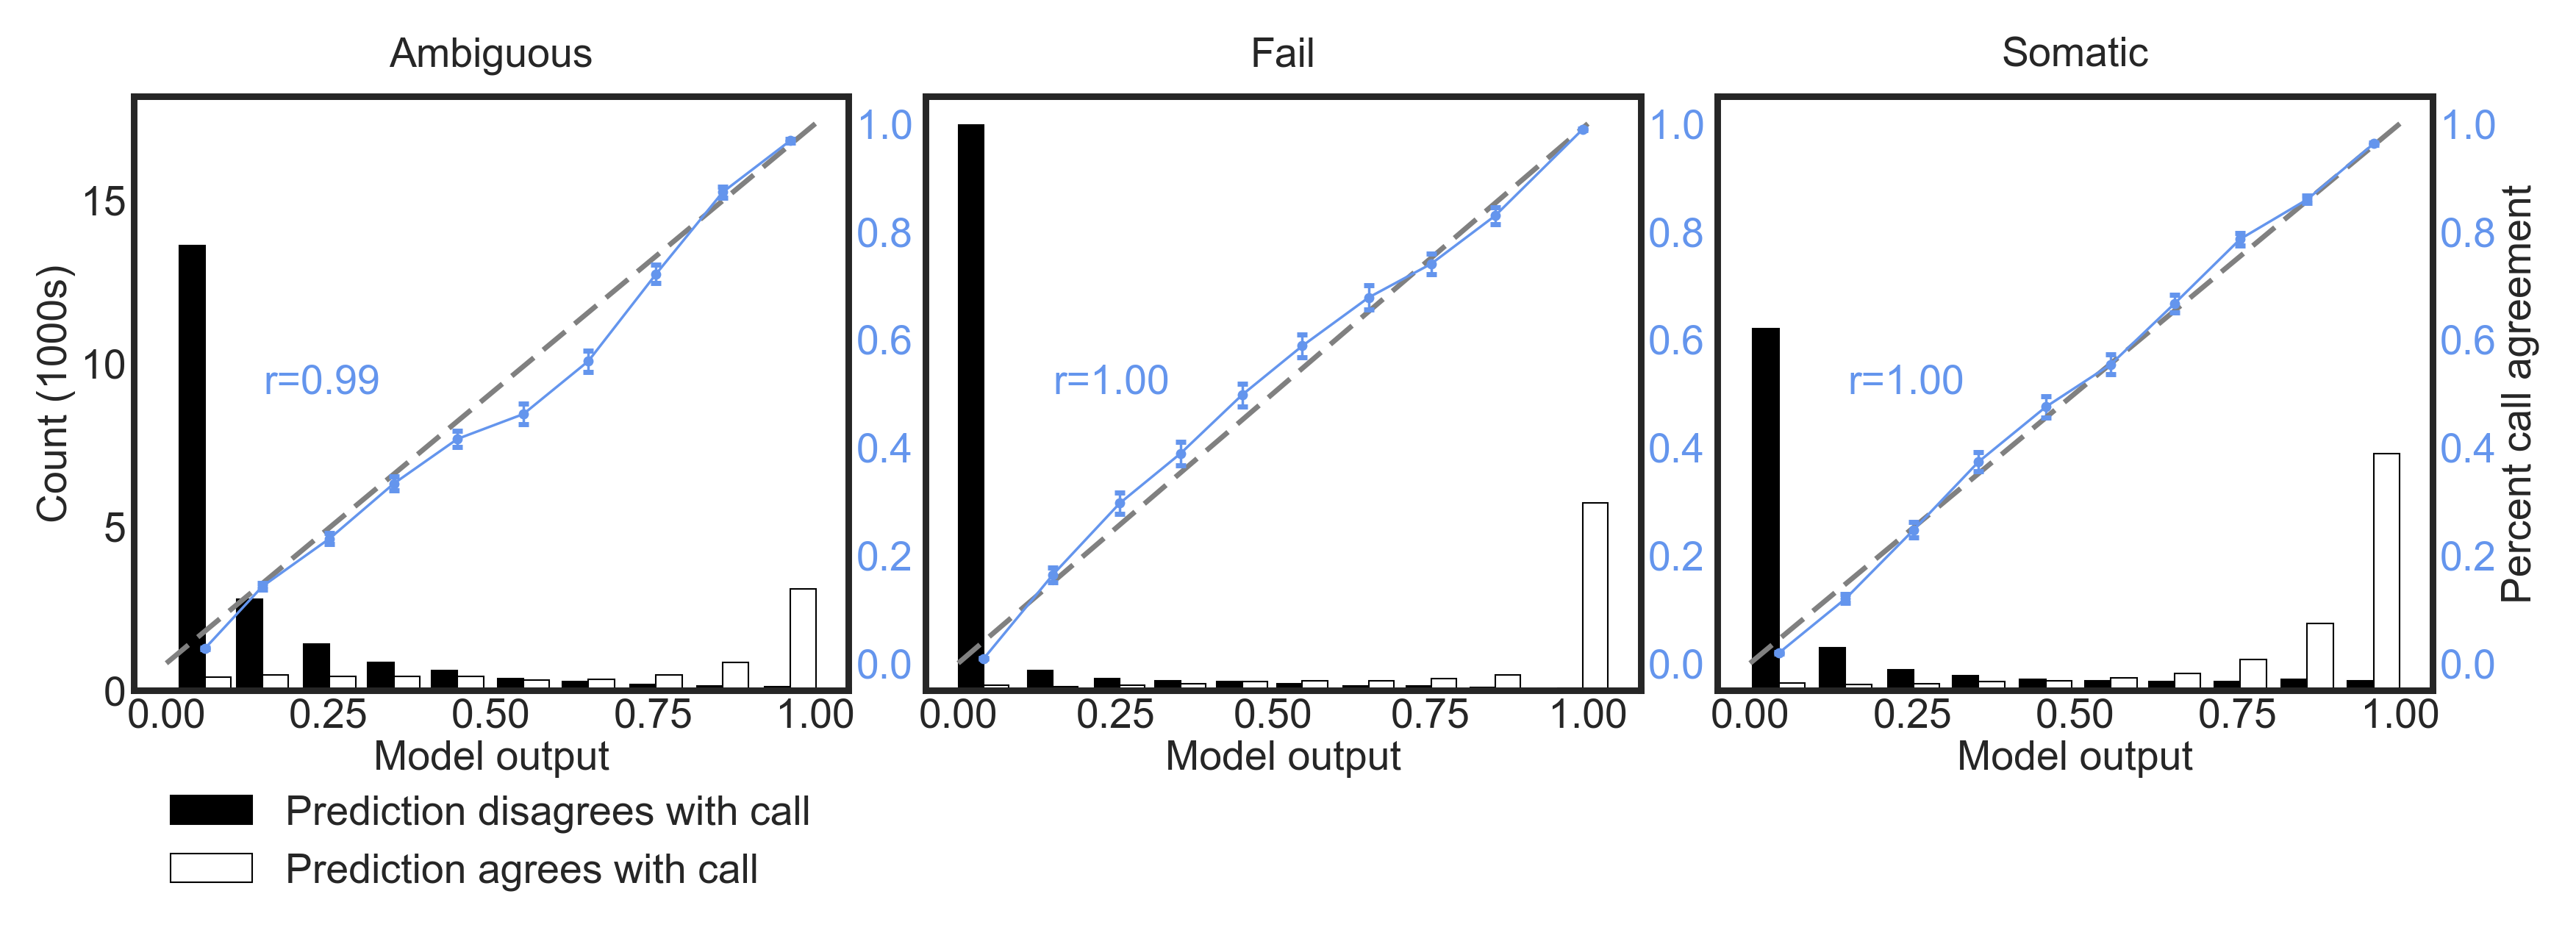

In [10]:

fig, axes = plt.subplots(1, 3, figsize=(7, 2.25), dpi=500, sharey=True)
plt.tight_layout( w_pad=.1)
lgd = create_reliability_diagram(threeclass_relu_probs[:,:1], Y_train[:,:1],['Ambiguous'], 'cornflowerblue', 'Ambiguous',
                           axes[0], False, True, True)
create_reliability_diagram(threeclass_relu_probs[:,1:2], Y_train[:,1:2],['Fail'], 'cornflowerblue', 'Fail',
                           axes[1], False, False, False)
create_reliability_diagram(threeclass_relu_probs[:,2:3], Y_train[:,2:3],['Somatic'], 'cornflowerblue', 'Somatic',
                           axes[2], True, False, False)
fig.savefig('../figures/compare_classes_reliability.png', bbox_extra_artists=(lgd,), bbox_inches='tight')
fig.savefig('../figures/compare_classes_reliability.pdf', bbox_extra_artists=(lgd,), bbox_inches='tight')

confidence intervals +-:  [ 0.0008389   0.00627242  0.01057244  0.01283678  0.01468779  0.01572641
  0.01478741  0.01218587  0.00731854  0.00175012]
confidence intervals +-:  [ 0.00052711  0.00341899  0.00591098  0.00770761  0.00878128  0.00920147
  0.00858137  0.00659154  0.00397114  0.00108244]
confidence intervals +-:  [ 0.00054063  0.00342791  0.00562326  0.00748434  0.00815918  0.00873999
  0.00808578  0.00647762  0.00413643  0.0011306 ]


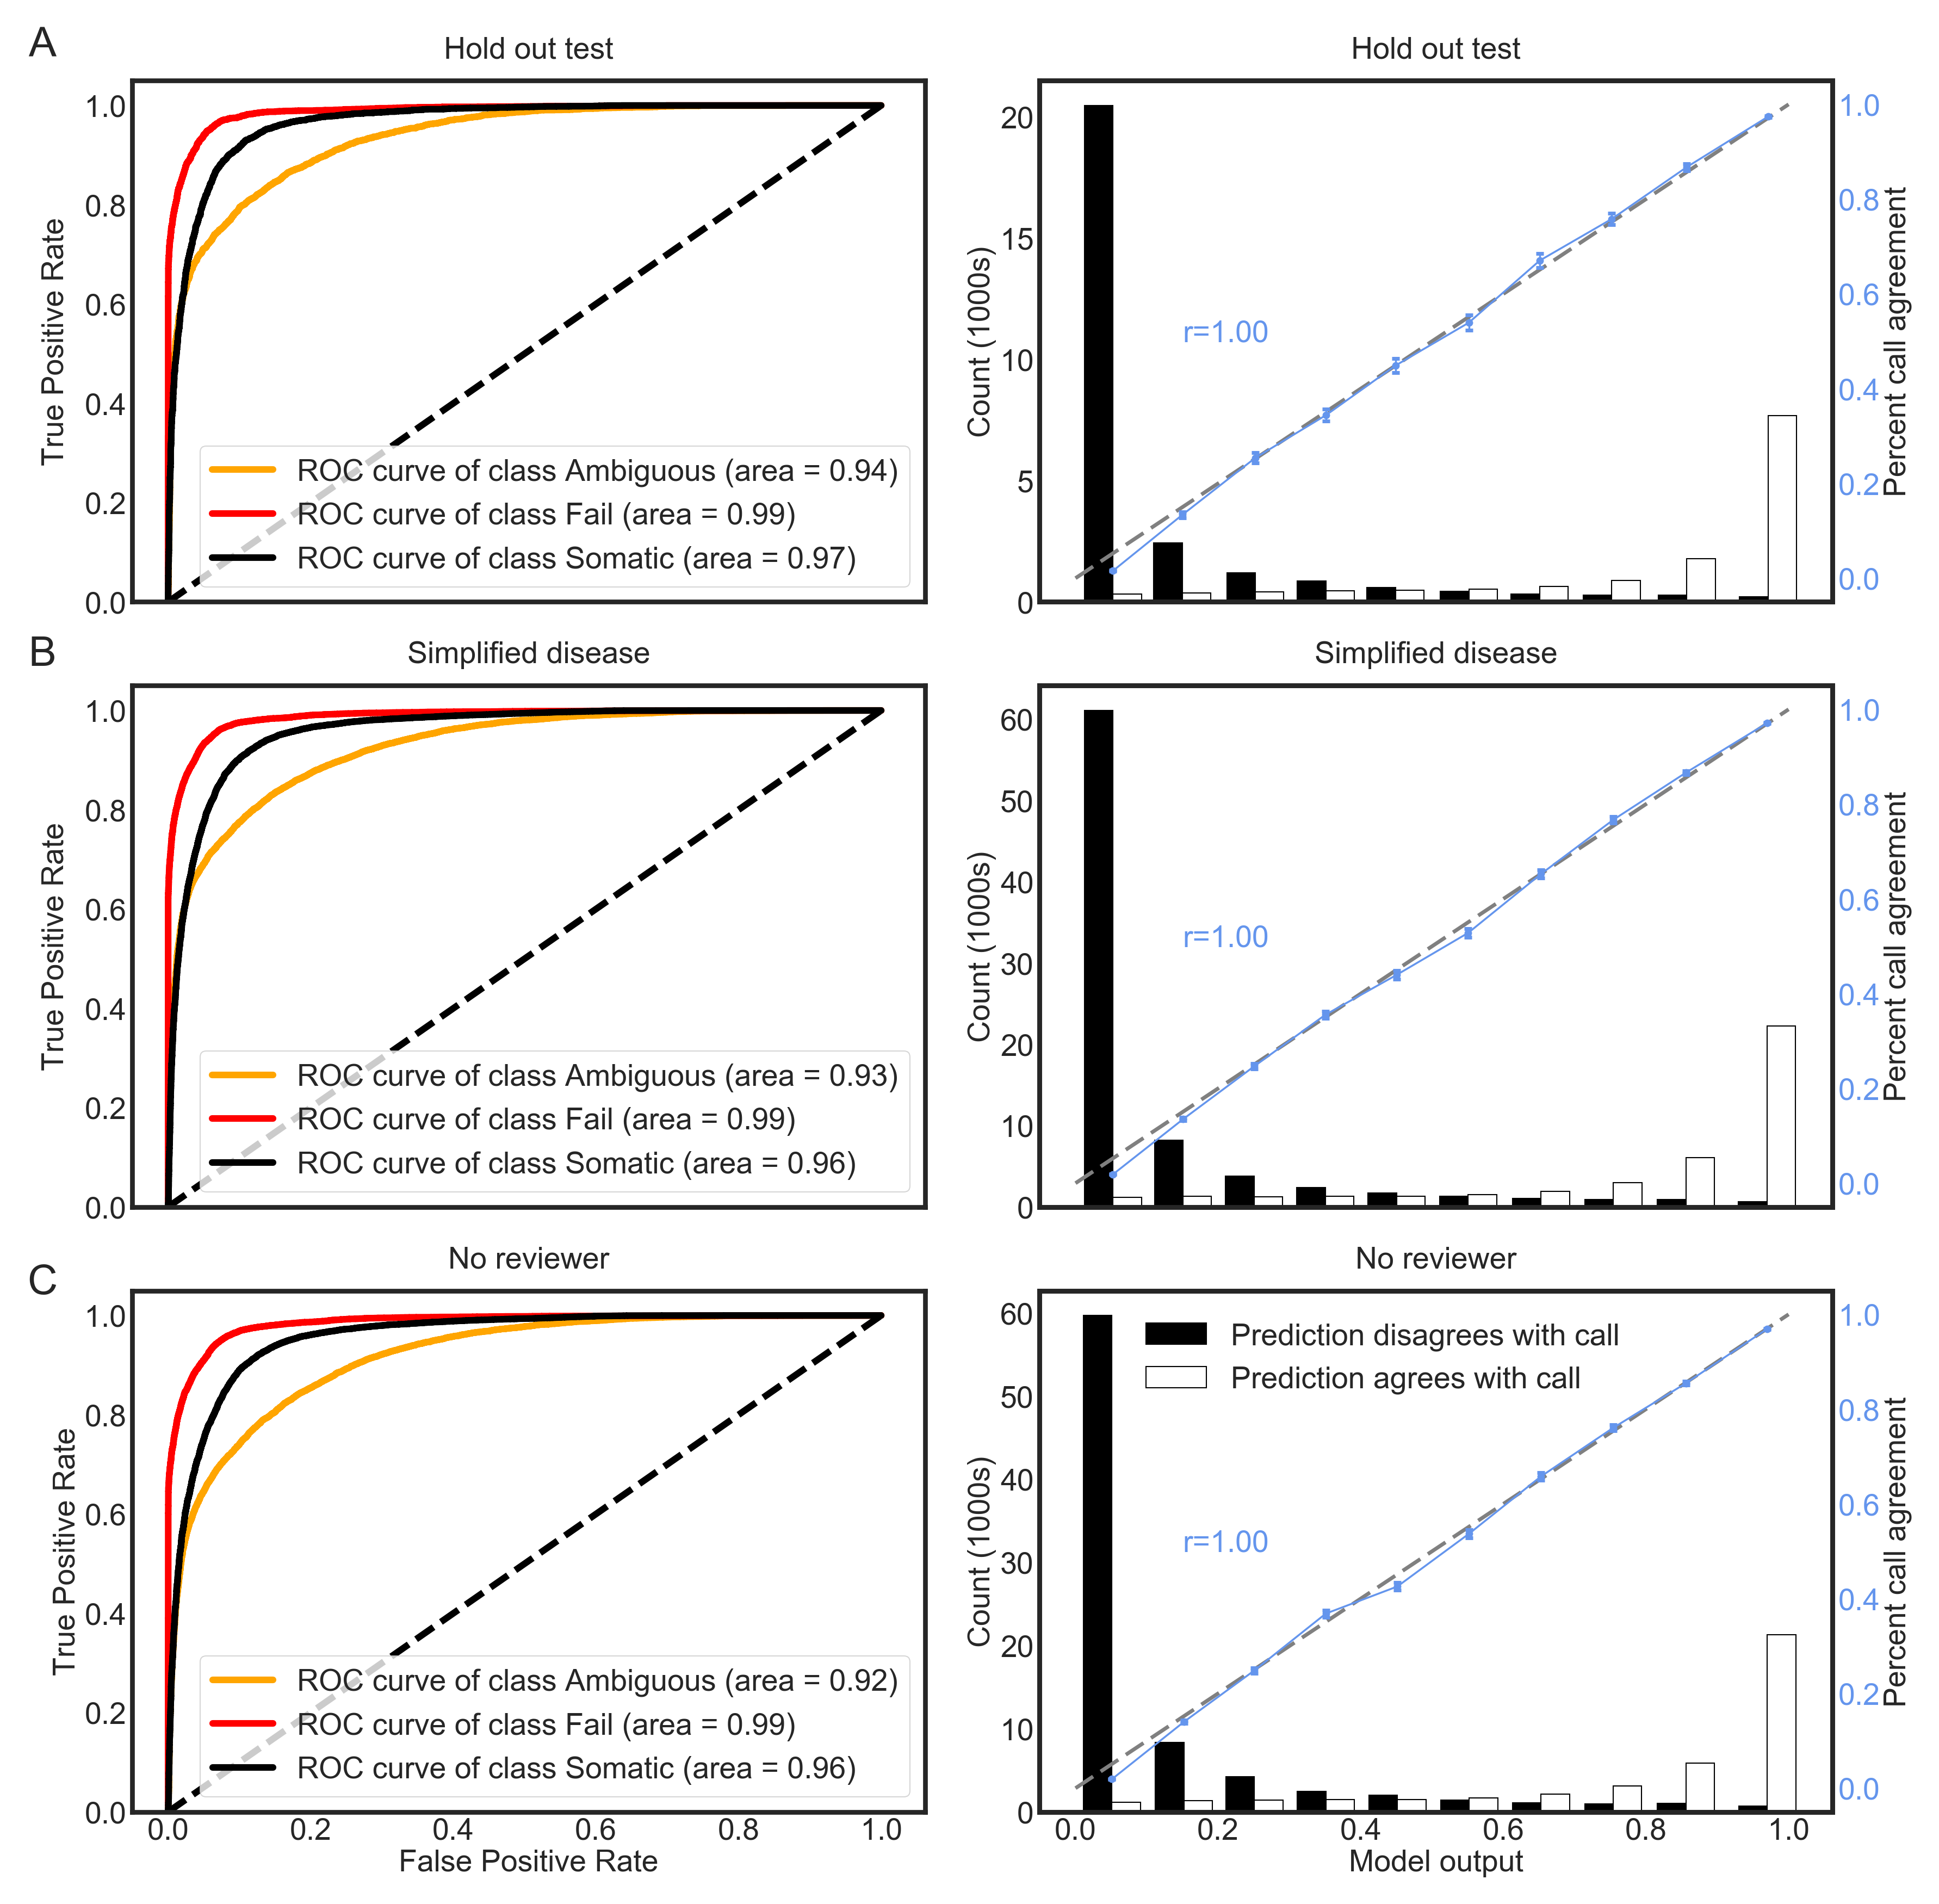

In [11]:
hold_out_test_probs = np.load('../data/deep_learning/hold_out_test_probs.npy')
hold_out_test_y = np.load('../data/deep_learning/hold_out_test_y.npy')
svb_probs = np.load('../data/deep_learning/solid_v_blood_regularization.npy')
svb_y = np.load('../data/deep_learning/solid_v_blood_y.npy')
no_reviewer_probs = np.load('../data/deep_learning/noreviewer_probs_regularization.npy')

fig, axes = plt.subplots(3, 2, figsize=(7, 7), dpi=500, sharex=True)
plt.tight_layout( w_pad=.2)
class_lookup = {0: 'Ambiguous', 1: 'Fail', 2: 'Somatic'}


create_roc_curve(hold_out_test_y,hold_out_test_probs,class_lookup,'Hold out test',axes[0,0])
axes[0,0].legend(fontsize=8, loc=4,frameon=True)
axes[0,0].tick_params(labelsize=8, pad=1.5)
axes[0,0].set_ylabel('True Positive Rate', fontsize=8)
axes[0,0].set_xlabel('')
axes[0,0].set_title('Hold out test', fontsize=8)
create_reliability_diagram(hold_out_test_probs, hold_out_test_y,['Ambiguous','Fail','Somatic'], 'cornflowerblue', 'Hold out test',
                           axes[0,1], True, True, False)
axes[0,1].set_xlabel('')

create_roc_curve(svb_y,svb_probs,class_lookup,'Simplified disease',axes[1,0])
axes[1,0].legend(fontsize=8, loc=4,frameon=True)
axes[1,0].tick_params(labelsize=8, pad=1.5)
axes[1,0].set_ylabel('True Positive Rate', fontsize=8)
axes[1,0].set_xlabel('')
axes[1,0].set_title('Simplified disease', fontsize=8)
create_reliability_diagram(svb_probs, svb_y,['Ambiguous','Fail','Somatic'], 'cornflowerblue', 'Simplified disease',
                           axes[1,1], True, True, False)
axes[1,1].set_xlabel('')

create_roc_curve(svb_y,no_reviewer_probs,class_lookup,'No reviewer',axes[2,0])
axes[2,0].legend(fontsize=8, loc=4,frameon=True)
axes[2,0].tick_params(labelsize=8, pad=1.5)
axes[2,0].set_ylabel('True Positive Rate', fontsize=8)
axes[2,0].set_xlabel('False Positive Rate', fontsize=8)
axes[2,0].set_title('No reviewer', fontsize=8)
axes[2,0].yaxis.labelpad = 1
axes[2,0].xaxis.labelpad = 1
lgd = create_reliability_diagram(no_reviewer_probs, svb_y,['Ambiguous','Fail','Somatic'], 'cornflowerblue', 'No reviewer',
                                 axes[2,1], True, True, True)
lgd.set_bbox_to_anchor((.1,.75))
fig.text(.02, .98, 'A', ha='center', fontsize=11)
fig.text(.02, .66, 'B', ha='center', fontsize=11)
fig.text(.02, .33, 'C', ha='center', fontsize=11)

fig.savefig('../figures/sup_fig.png', bbox_extra_artists=(lgd,), bbox_inches='tight')
fig.savefig('../figures/sup_fig.pdf', bbox_extra_artists=(lgd,), bbox_inches='tight')

In [12]:
dl_sclc_auc = pd.read_pickle('../data/deep_learning/sclc_batch_effect_correction_dropout.pkl')

rf_sclc_auc = pd.read_pickle('../data/random_forest/sclc_batch_effect_correction.pkl')

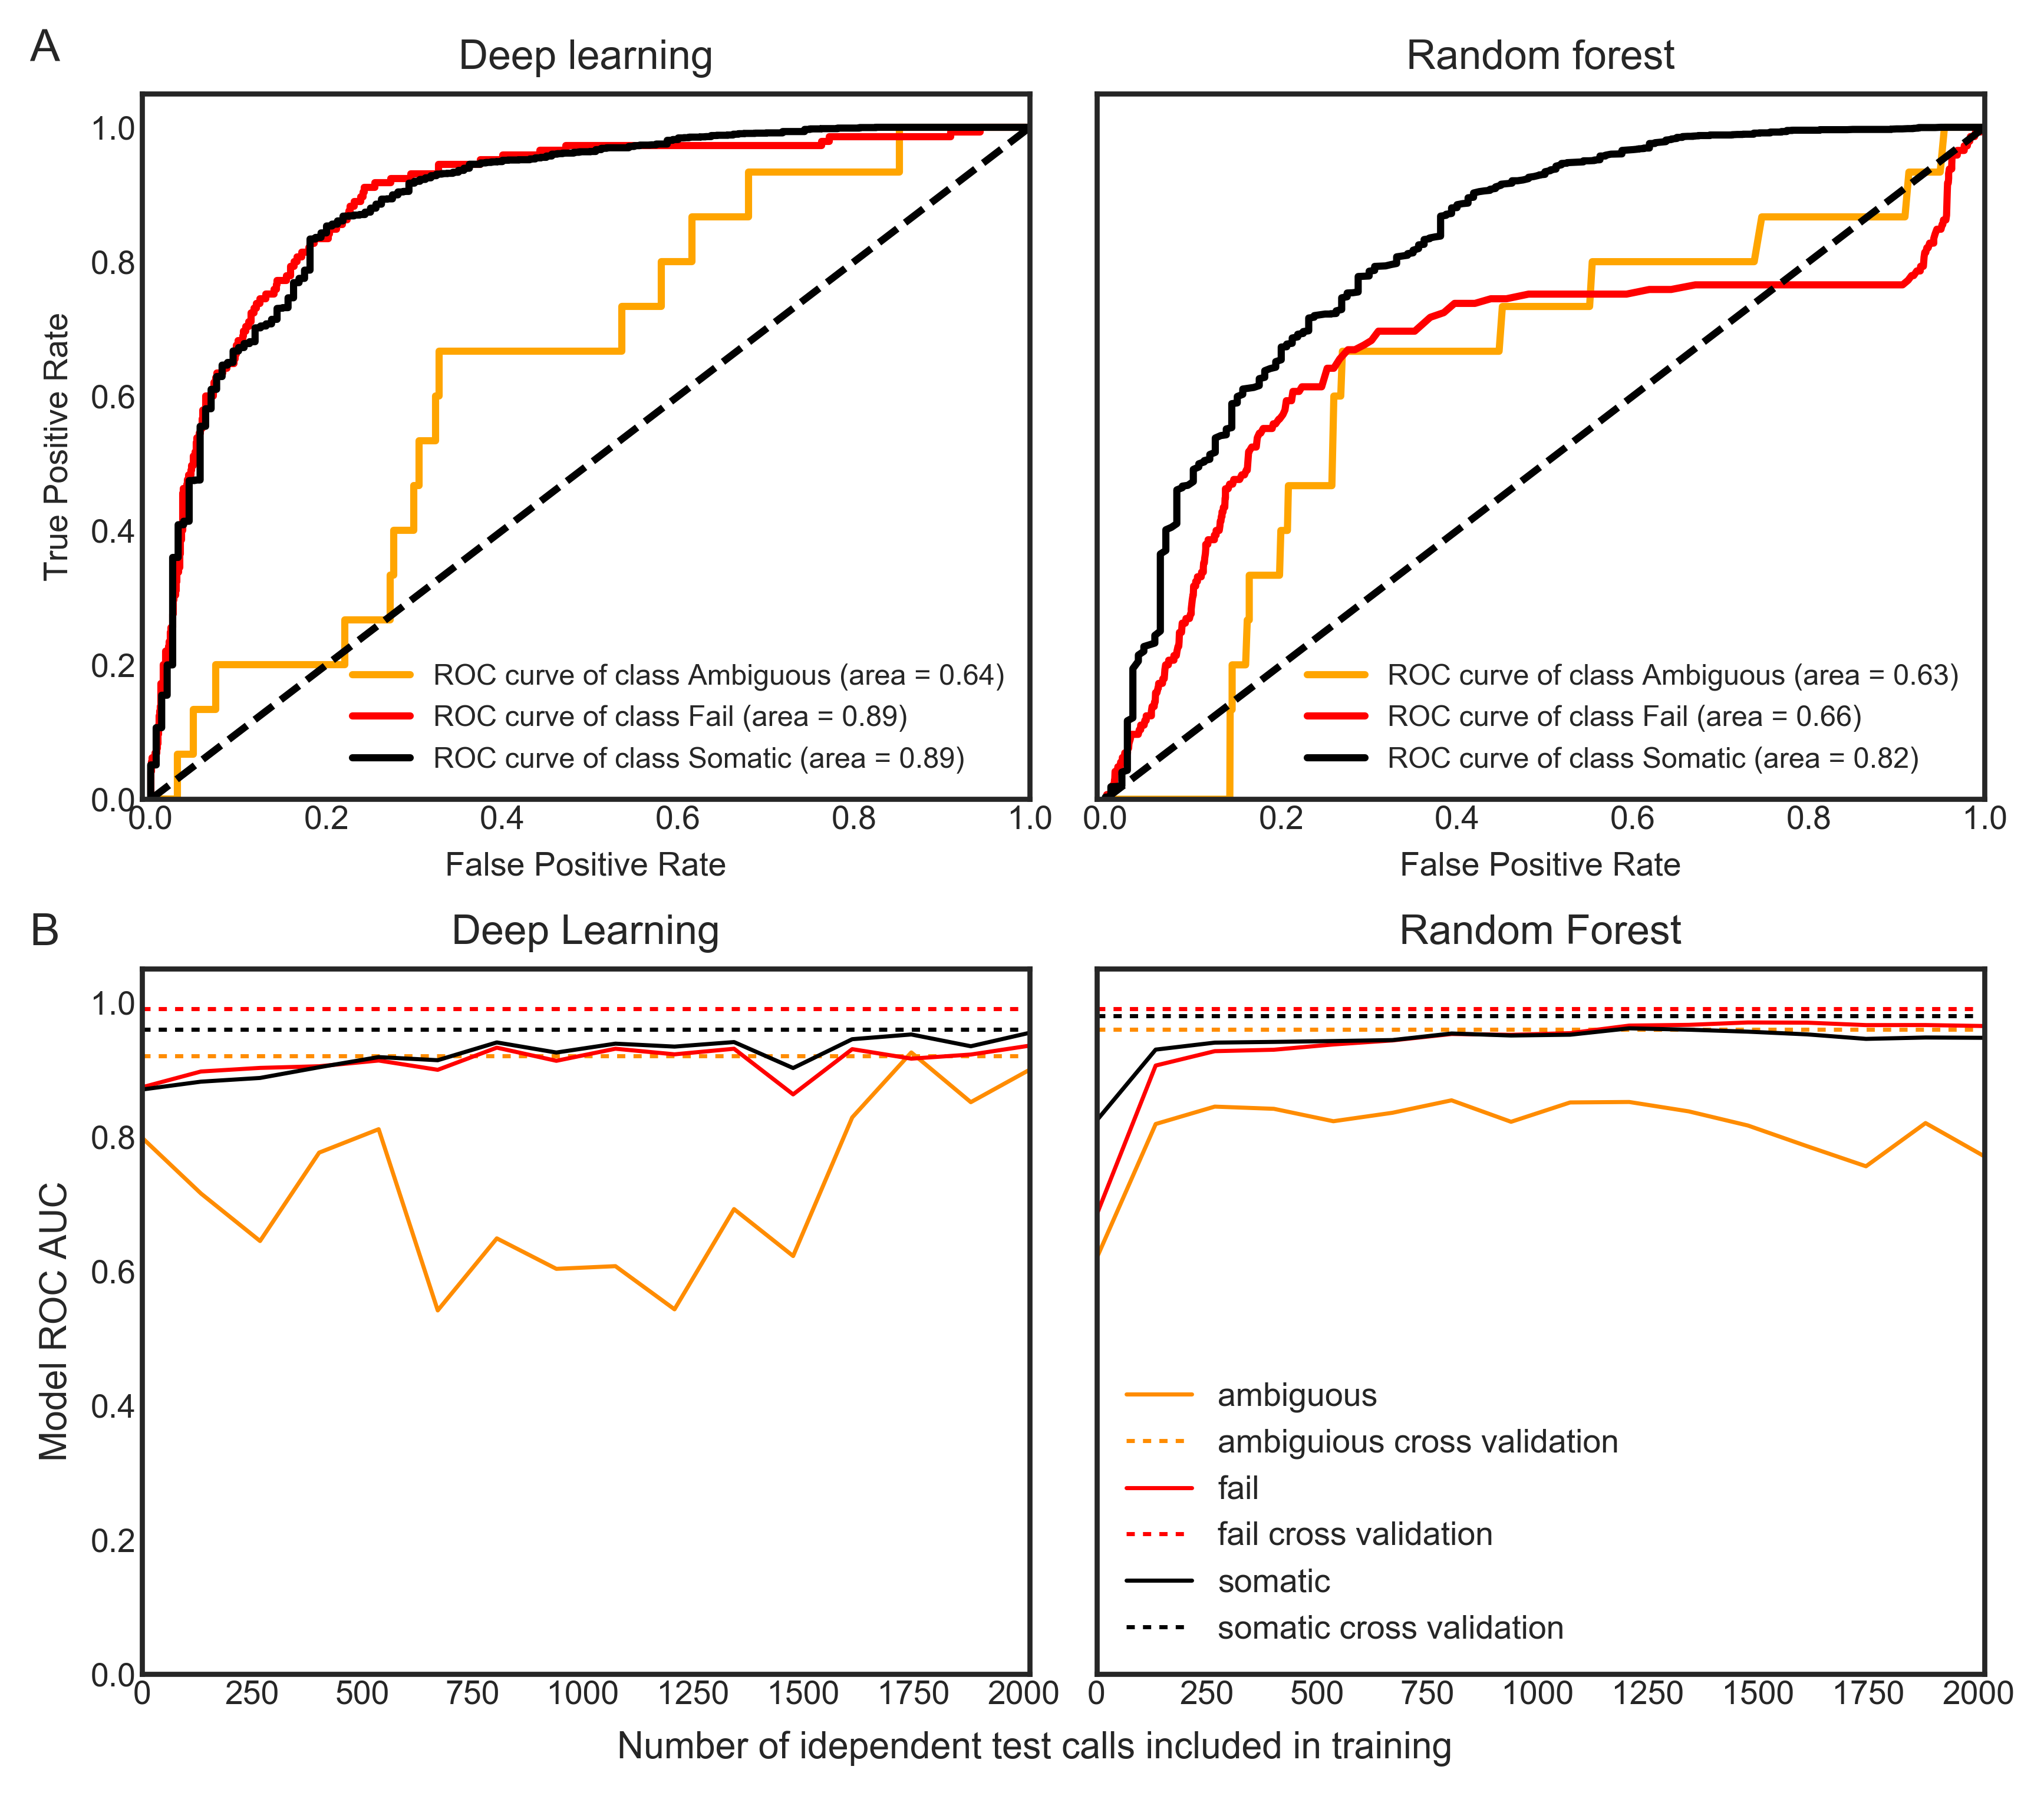

In [13]:
rf_sclc_y = np.load('../data/random_forest/sclc_y.npy')
rf_sclc_probs = np.load('../data/random_forest/sclc_probs.npy')
dl_sclc_y = np.load('../data/deep_learning/sclc_y.npy')
dl_sclc_probs = np.load('../data/deep_learning/sclc_probs.npy')
fig, ((ax1, ax2),(ax3, ax4)) = plt.subplots(2,2, figsize=(7,6),dpi=500, sharey=True)
plt.tight_layout( w_pad=.2, h_pad=1.8)
create_roc_curve(dl_sclc_y, dl_sclc_probs, class_lookup, 'Deep learning', ax1)
create_roc_curve(rf_sclc_y, rf_sclc_probs, class_lookup, 'Random forest', ax2)
ax1.legend(fontsize=7)
ax2.legend(fontsize=7)
ax2.set_ylabel('')
ax1.set_ylabel('True Positive Rate', fontsize=8)
ax2.set_xlabel('False Positive Rate', fontsize=8)
ax1.set_xlabel('False Positive Rate', fontsize=8)
ax1.set_title('Deep learning', fontsize=10)
ax2.set_title('Random forest', fontsize=10)
ax1.tick_params(labelsize=8, pad=1.5)
ax2.tick_params(labelsize=8, pad=1.5)
# fig.suptitle('SCLC independent test set performance',y=1.02)

dl_sclc_auc.plot(x='num. test samples in training', y='ambiguous', ax=ax3, color='darkorange', linewidth=1)
ax3.plot([0, 2000], [.92,.92], linestyle='--', dashes=(1, 1),color='darkorange', 
             label='ambiguious cross validation', linewidth=1)
dl_sclc_auc.plot(x='num. test samples in training', y='fail', ax=ax3, color='red', linewidth=1)
ax3.plot([0, 2000], [.99,.99], linestyle='--', dashes=(1, 1),color='red', label='fail cross validation', linewidth=1)
dl_sclc_auc.plot(x='num. test samples in training', y='somatic', ax=ax3, color='black', linewidth=1)
ax3.plot([0, 2000], [.96,.96], linestyle='--', dashes=(1, 1),color='black', label='somatic cross validation', linewidth=1)
ax3.set_ylabel('Model ROC AUC',fontsize=9)
ax3.set_xlabel('')
ax3.legend_.remove()
ax3.set_title('Deep Learning', fontsize=10)
ax3.tick_params(labelsize=8, pad=1.5)
rf_sclc_auc.plot(x='num. test samples in training', y='ambiguous', ax=ax4, color='darkorange', linewidth=1)
ax4.plot([0, 2000], [.96,.96], linestyle='--', dashes=(1, 1),color='darkorange', 
             label='ambiguious cross validation', linewidth=1)
rf_sclc_auc.plot(x='num. test samples in training', y='fail', ax=ax4, color='red', linewidth=1)
ax4.plot([0, 2000], [.99,.99], linestyle='--', dashes=(1, 1),color='red', label='fail cross validation', linewidth=1)
rf_sclc_auc.plot(x='num. test samples in training', y='somatic', ax=ax4, color='black', linewidth=1)
ax4.plot([0, 2000], [.98,.98], linestyle='--', dashes=(1, 1),color='black', label='somatic cross validation', linewidth=1)
ax4.set_ylabel('Model ROC AUC', fontsize=9)
ax4.set_xlabel('')
ax4.legend(fontsize=8)
ax4.set_title('Random Forest', fontsize=10)
ax4.tick_params(labelsize=8, pad=1.5)
fig.text(.5, 0.02, 'Number of idependent test calls included in training', ha='center', fontsize=9)
fig.text(.02, .98, 'A', ha='center', fontsize=11)
fig.text(.02, .48, 'B', ha='center', fontsize=11)


fig.savefig('../figures/independent_test.png') 
fig.savefig('../figures/independent_test.pdf') 

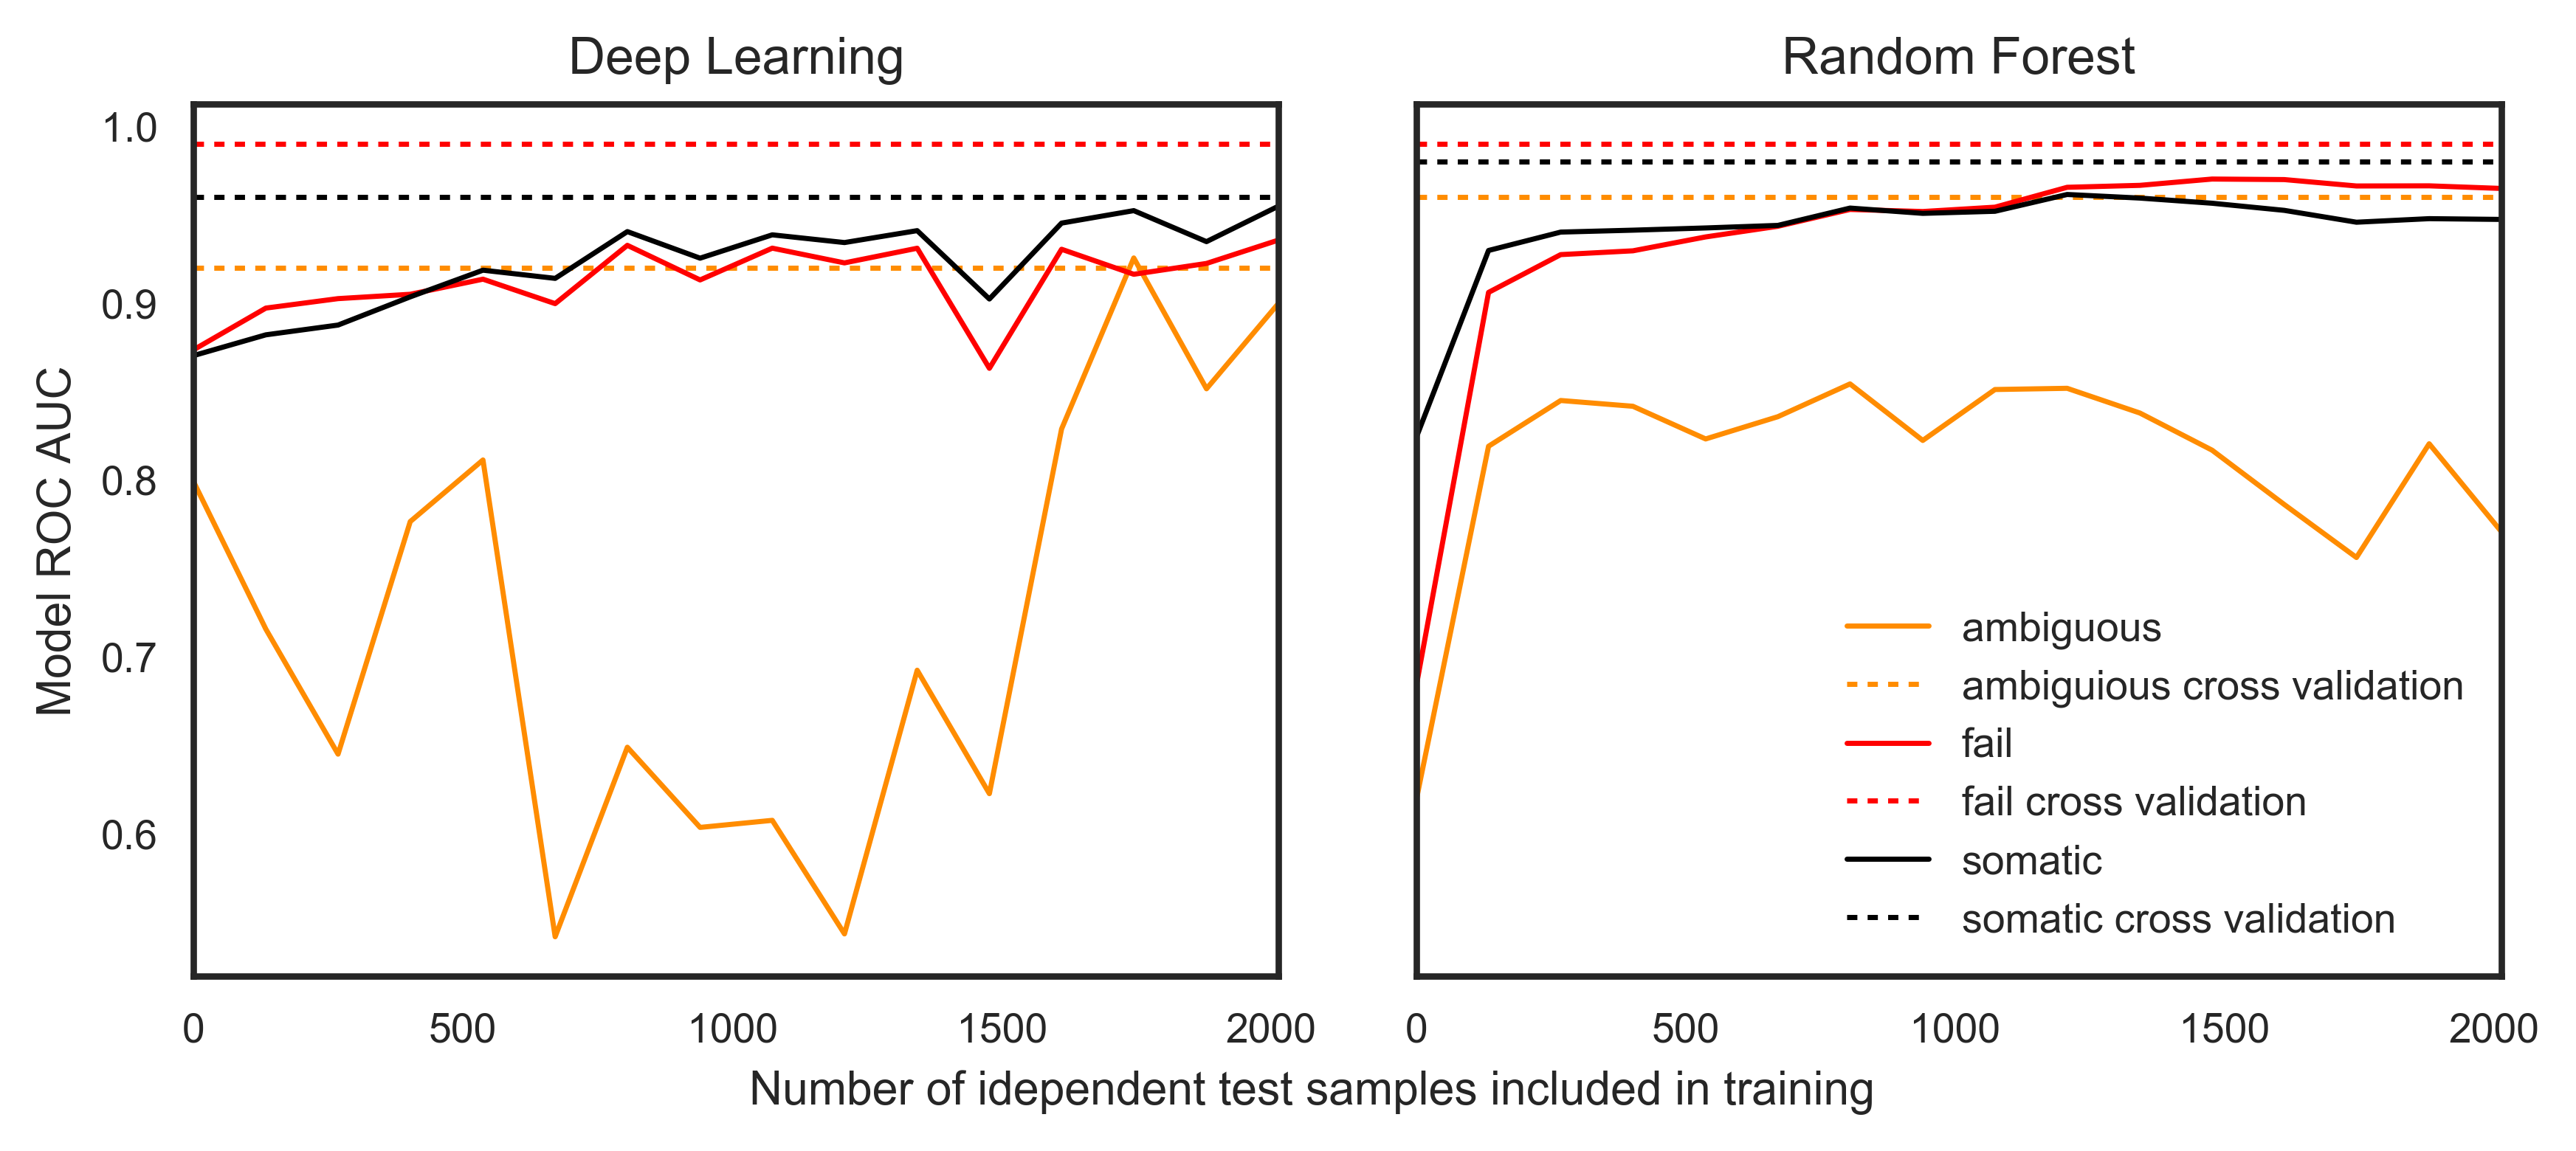

In [14]:

fig, axes = plt.subplots(1,2, figsize=(7,3),dpi=500, sharey=True)
plt.tight_layout()
dl_sclc_auc.plot(x='num. test samples in training', y='ambiguous', ax=axes[0], color='darkorange', linewidth=1)
axes[0].plot([0, 2000], [.92,.92], linestyle='--', dashes=(1, 1),color='darkorange', 
             label='ambiguious cross validation', linewidth=1)
dl_sclc_auc.plot(x='num. test samples in training', y='fail', ax=axes[0], color='red', linewidth=1)
axes[0].plot([0, 2000], [.99,.99], linestyle='--', dashes=(1, 1),color='red', label='fail cross validation', linewidth=1)
dl_sclc_auc.plot(x='num. test samples in training', y='somatic', ax=axes[0], color='black', linewidth=1)
axes[0].plot([0, 2000], [.96,.96], linestyle='--', dashes=(1, 1),color='black', label='somatic cross validation', linewidth=1)
axes[0].set_ylabel('Model ROC AUC',fontsize=9)
axes[0].set_xlabel('')
axes[0].legend_.remove()
axes[0].set_title('Deep Learning', fontsize=10)
axes[0].tick_params(labelsize=8)
rf_sclc_auc.plot(x='num. test samples in training', y='ambiguous', ax=axes[1], color='darkorange', linewidth=1)
axes[1].plot([0, 2000], [.96,.96], linestyle='--', dashes=(1, 1),color='darkorange', 
             label='ambiguious cross validation', linewidth=1)
rf_sclc_auc.plot(x='num. test samples in training', y='fail', ax=axes[1], color='red', linewidth=1)
axes[1].plot([0, 2000], [.99,.99], linestyle='--', dashes=(1, 1),color='red', label='fail cross validation', linewidth=1)
rf_sclc_auc.plot(x='num. test samples in training', y='somatic', ax=axes[1], color='black', linewidth=1)
axes[1].plot([0, 2000], [.98,.98], linestyle='--', dashes=(1, 1),color='black', label='somatic cross validation', linewidth=1)
axes[1].set_ylabel('Model ROC AUC', fontsize=9)
axes[1].set_xlabel('')
axes[1].legend(fontsize=8)
axes[1].set_title('Random Forest', fontsize=10)
axes[1].tick_params(labelsize=8)
fig.text(.5, 0.02, 'Number of idependent test samples included in training', ha='center', fontsize=9)
fig.savefig('../figures/batch_effect_correction.png')
fig.savefig('../figures/batch_effect_correction.pdf')

In [15]:
def sum_features(feature_import, label):
    starts_with_label = feature_import.Features.str.startswith(label)
    return feature_import['Ranked importance'][starts_with_label].sum()

In [16]:
manual_reviewer_feature_rankings = pd.read_csv('../data/manual_reviewer_feature_rankings.txt', sep='\t')
manual_reviewer_feature_rankings.columns = ['Features', 'Ranked importance']
summed_importances = []
for label in ['disease', 'reviewer']:
    summed_importances.append([label, sum_features(manual_reviewer_feature_rankings, label)])
summed_importances = pd.DataFrame(summed_importances, columns=['Features', 'Ranked importance'])
continuous_importances = manual_reviewer_feature_rankings[(~manual_reviewer_feature_rankings['Features'].str.contains('reviewer'))&
                                        (~manual_reviewer_feature_rankings['Features'].str.contains('disease'))]
manual_reviewer_feature_rankings = pd.concat([continuous_importances,summed_importances])
manual_reviewer_feature_rankings.replace(
        {'Features': {'var': 'variant', 'ref': 'reference',
                     'avg': 'average',
                     '_se_': '_single_end_',
                     '3p': '3_prime', '_': ' '}},
        regex=True, inplace=True)
manual_reviewer_feature_rankings = manual_reviewer_feature_rankings[manual_reviewer_feature_rankings.Features != 'TOTAL']
manual_reviewer_feature_rankings.shape

deep_learning_feature_import = pd.read_pickle('../data/deep_learning/feature_import.pkl')
deep_learning_feature_import.columns = ['Features', 'Shuffed AUC', 'Delta AUC']
deep_learning_feature_import.replace(
        {'Features': {'var': 'variant', 'ref': 'reference',
                     'avg': 'average',
                     '_se_': '_single_end_',
                     '3p': '3_prime', '_': ' '}},
        regex=True, inplace=True)

random_forest_feature_import = pd.read_pickle('../data/random_forest/feature_import.pkl')
random_forest_feature_import.columns = ['Features', 'Importance']
random_forest_feature_import.replace(
        {'Features': {'var': 'variant', 'ref': 'reference',
                     'avg': 'average',
                     '_se_': '_single_end_',
                     '3p': '3_prime', '_': ' '}},
        regex=True, inplace=True)


In [17]:
feature_import = pd.merge(pd.merge(manual_reviewer_feature_rankings, deep_learning_feature_import, on='Features'), random_forest_feature_import, on='Features', suffixes=('_mr', '_rf')).drop('Shuffed AUC', axis=1)

In [18]:
# source https://github.com/ShawnLYU/Quantile_Normalize
def quantileNormalize(df_input):
    df = df_input.copy()
    #compute rank
    dic = {}
    for col in df:
        dic.update({col : sorted(df[col])})
    sorted_df = pd.DataFrame(dic)
    rank = sorted_df.mean(axis = 1).tolist()
    #sort
    for col in df:
        t = np.searchsorted(np.sort(df[col]), df[col])
        df[col] = [rank[i] for i in t]
    return df

In [19]:
feature_import.set_index('Features', inplace=True)

In [20]:
feature_import.columns= ['Manual reviewer', 'Deep learning', 'Random forest']

In [21]:
feature_import_norm = quantileNormalize(feature_import)

In [22]:
feature_import_norm.corr()

Manual reviewer  Deep learning  Random forest
Manual reviewer         1.000000       0.115124       0.488688
Deep learning           0.115124       1.000000       0.473991
Random forest           0.488688       0.473991       1.000000

In [23]:
import seaborn as sns

In [24]:
mean_feature_import = feature_import_norm
mean_feature_import['mean'] = mean_feature_import.mean(axis=1)
mean_feature_import = mean_feature_import.sort_values('mean', ascending=False)[['Manual reviewer', 'Deep learning', 'Random forest']][:30]

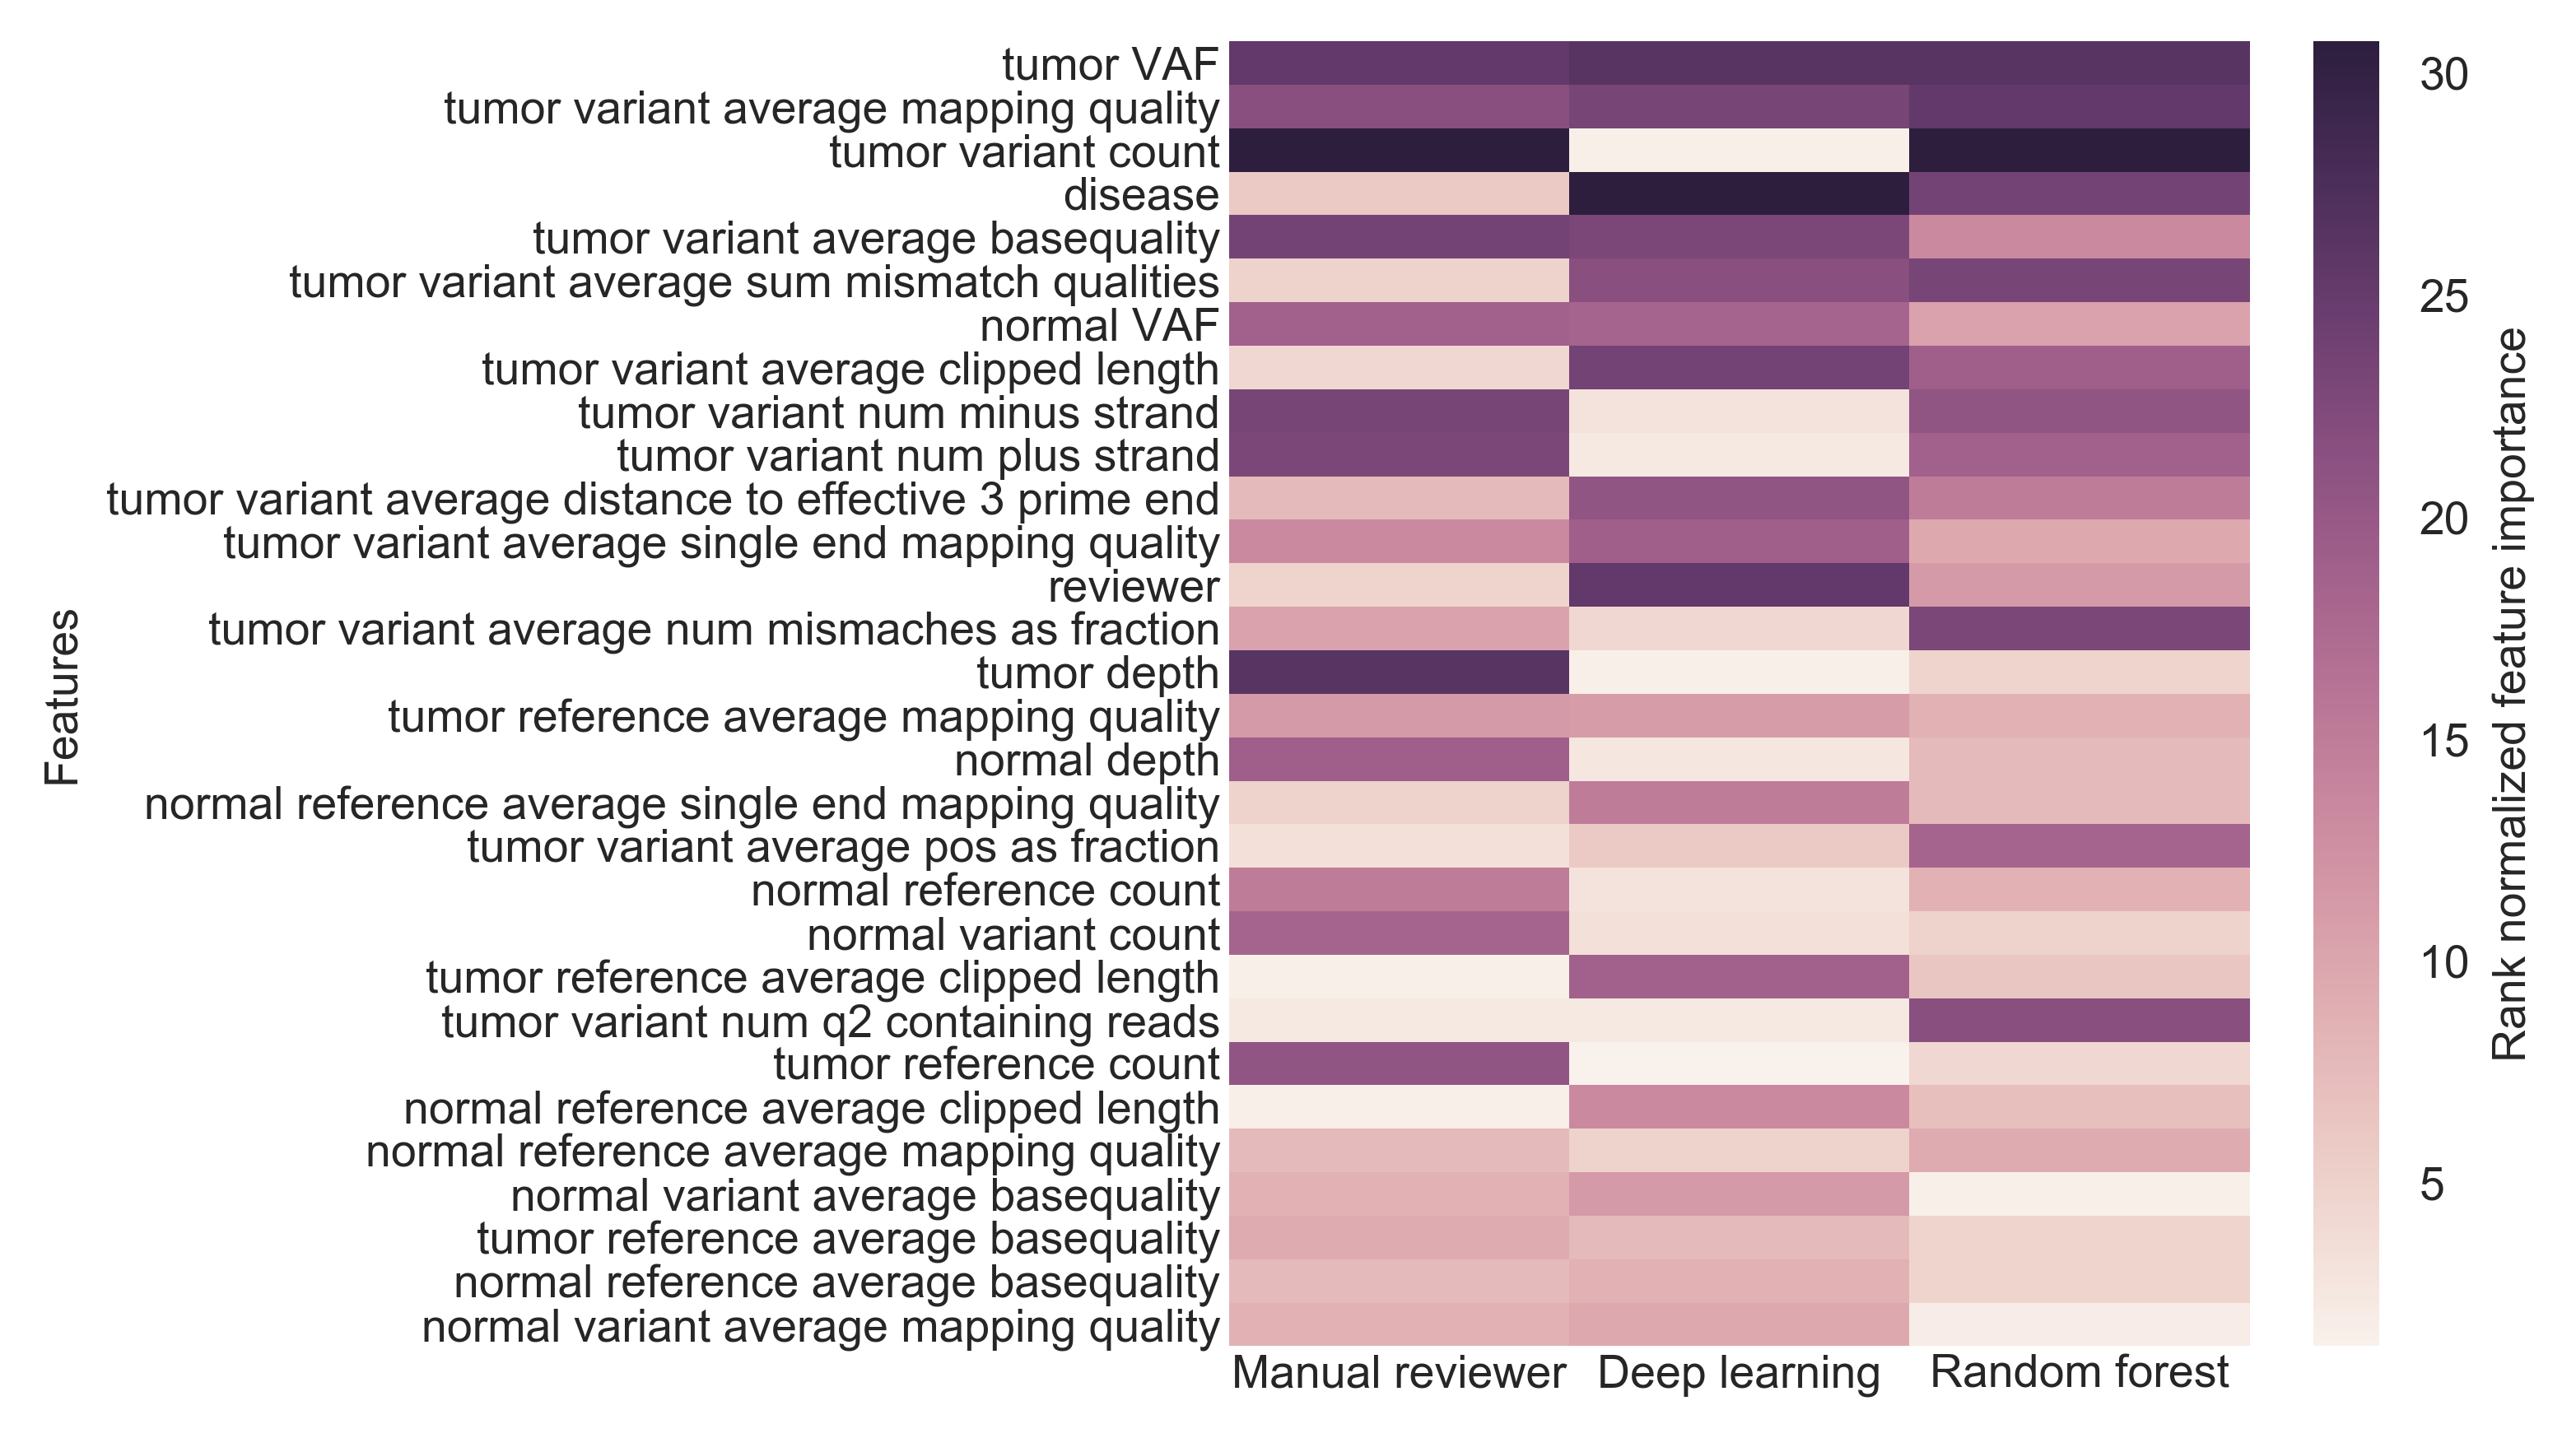

In [25]:
fig, ax = plt.subplots( figsize=(4,4.2),dpi=500)
sns.heatmap(mean_feature_import,ax=ax)
ax.collections[0].colorbar.set_label('Rank normalized feature importance', fontsize=8)
ax.tick_params(axis = 'y', labelsize=8, pad=1.5)
ax.tick_params(axis = 'x', labelsize=8, pad=1.5)
ax.set_ylabel('Features', fontsize=8)
# Set the colorbar axes font
cax = plt.gcf().axes[-1]
cax.tick_params(labelsize=8)
fig.savefig('../figures/feature_import.png',bbox_inches='tight')
fig.savefig('../figures/feature_import.pdf',bbox_inches='tight')

# Figure 6

In [27]:
rf_errors = pd.read_csv('../data/random_forest/rf_errors.tsv', sep='\t')
dl_errors = pd.read_csv('../data/deep_learning/dl_errors.tsv', sep='\t')

In [28]:
rf_error_counts = rf_errors.groupby(['disease','error']).size().unstack(fill_value=0)

TypeError: set_xticklabels() missing 1 required positional argument: 'labels'

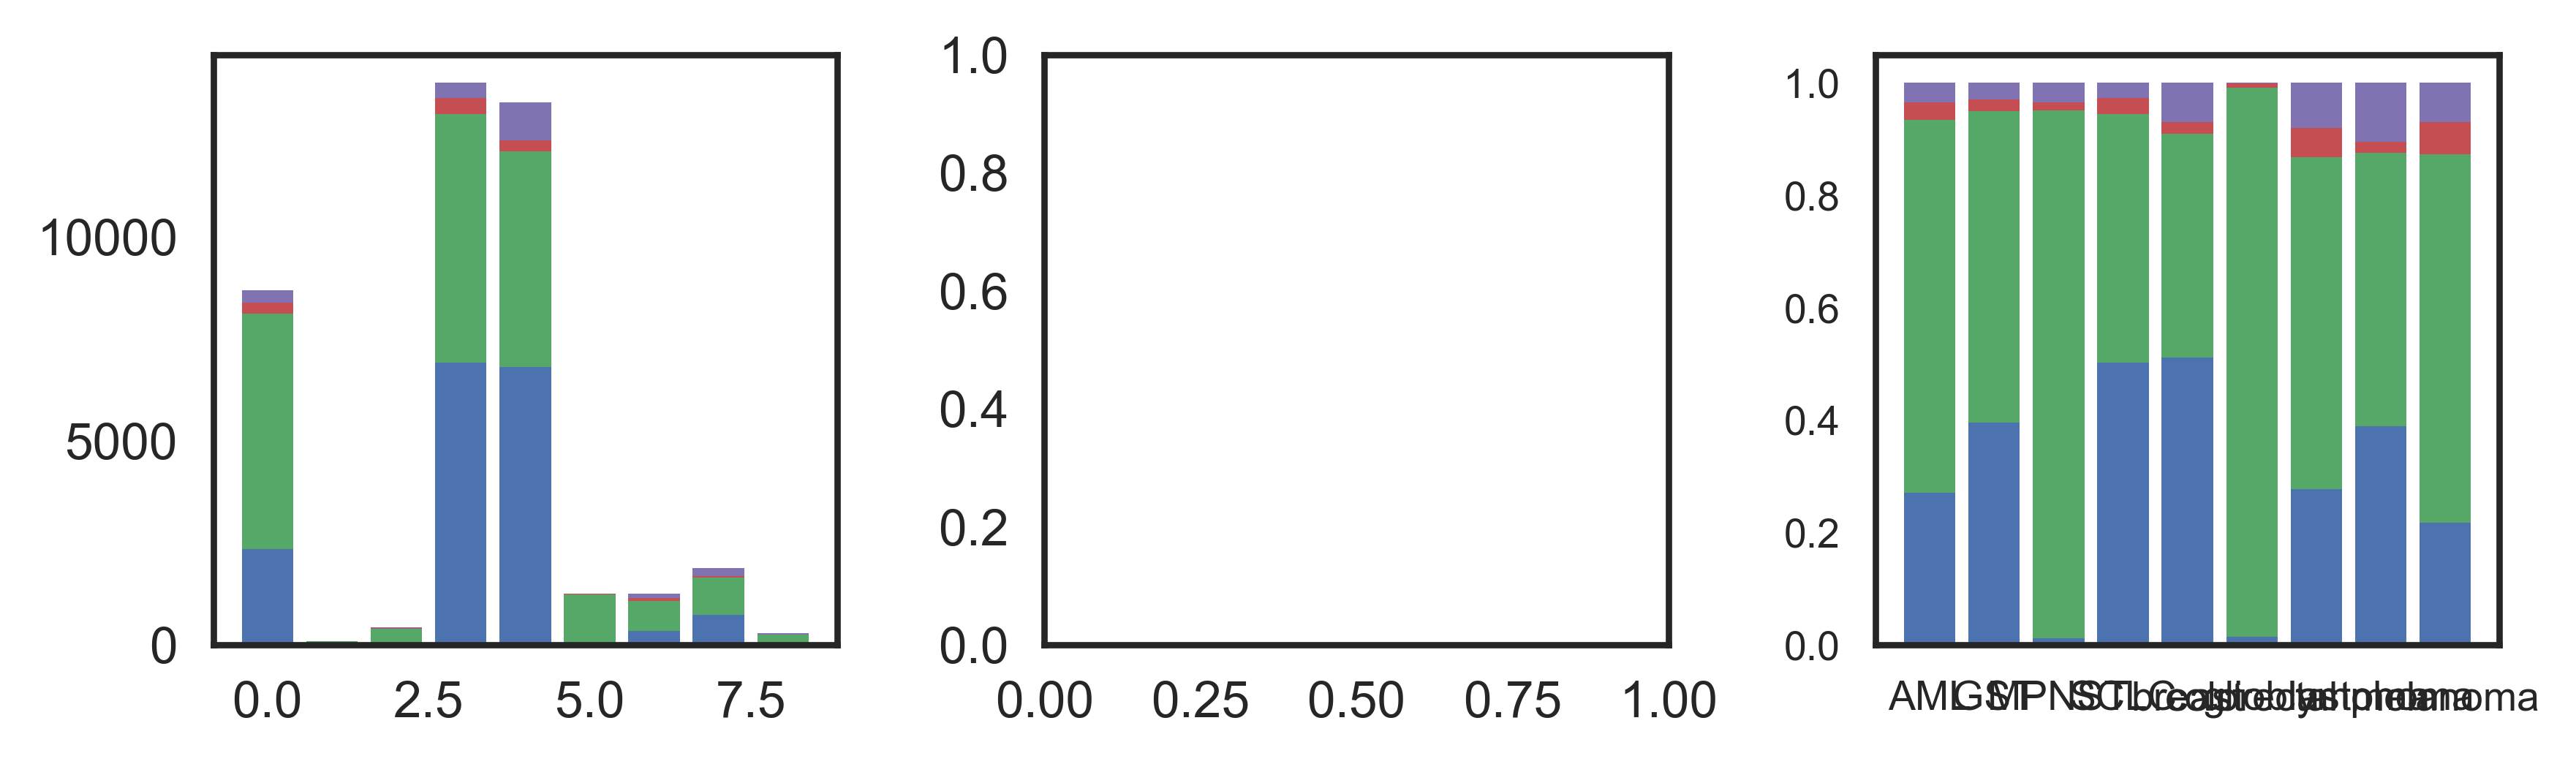

In [68]:
fig, ((ax1, ax2, ax3)) = plt.subplots(1,3, figsize=(7, 2.25),dpi=500)
plt.tight_layout()
tp = ax1.bar(np.arange(len(rf_error_counts)), rf_error_counts['True Positive'])
tn = ax1.bar(np.arange(len(rf_error_counts)), rf_error_counts['True Negative'], bottom=rf_error_counts['True Positive'])
fp = ax1.bar(np.arange(len(rf_error_counts)), rf_error_counts['False Positive'], bottom=rf_error_counts['True Positive']+rf_error_counts['True Negative'])
fn = ax1.bar(np.arange(len(rf_error_counts)), rf_error_counts['False Negative'], bottom=rf_error_counts['True Positive']+rf_error_counts['True Negative']+rf_error_counts['False Positive'])
# ax1.xticks(np.arange(len(rf_error_counts)), rf_error_counts.index.tolist(), rotation=45)
# ax1.legend((fn[0], fp[0], tn[0], tp[0]), ('False Negatives', 'False Positives', 'True Negatives', 'True Positives'))

rf_freqs = rf_error_counts.div(rf_error_counts.sum(axis=1), axis=0)

tp = ax3.bar(np.arange(len(rf_freqs)), rf_freqs['True Positive'],tick_label=rf_freqs.index.tolist())
tn = ax3.bar(np.arange(len(rf_freqs)), rf_freqs['True Negative'], bottom=rf_freqs['True Positive'])
fp = ax3.bar(np.arange(len(rf_freqs)), rf_freqs['False Positive'], bottom=rf_freqs['True Positive']+rf_freqs['True Negative'])
fn = ax3.bar(np.arange(len(rf_freqs)), rf_freqs['False Negative'], bottom=rf_freqs['True Positive']+rf_freqs['True Negative']+rf_freqs['False Positive'])
ax3.tick_params( labelsize=8)
for label in axs3.get_xmajorticklabels() + axs[1].get_xmajorticklabels():
    label.set_rotation(30)
    label.set_horizontalalignment("right")


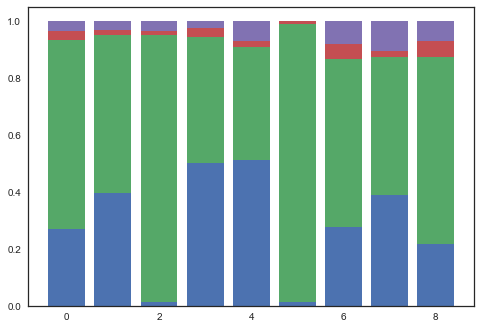

In [56]:
tp = plt.bar(np.arange(len(rf_freqs)), rf_freqs['True Positive'])
tn = plt.bar(np.arange(len(rf_freqs)), rf_freqs['True Negative'], bottom=rf_freqs['True Positive'])
fp = plt.bar(np.arange(len(rf_freqs)), rf_freqs['False Positive'], bottom=rf_freqs['True Positive']+rf_freqs['True Negative'])
fn = plt.bar(np.arange(len(rf_freqs)), rf_freqs['False Negative'], bottom=rf_freqs['True Positive']+rf_freqs['True Negative']+rf_freqs['False Positive'])



In [26]:
pd.read_pickle('../data/full_df.pkl')[['individual_name','chr','start','stop','ref','var']].drop_duplicates().groupby('individual_name').size().to_csv('../data/sites_per_sample', sep='\t')